In [1]:
from pathlib import Path 
import sys 
import pandas as pd
from functools import partial

sys.path.append('..')
from utils import extract_simulation_folder, process_outputs, process_additional_dataframe
from utils_plots import make_stacked_bar_subplots, read_plot_specs, process_for_labels, make_complete_fuel_dispatch_plot, make_multiple_lines_subplots, create_folders_imgs, subplot_scatter

# interactive features
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed

# Loading results

In [2]:
results_folder = Path('../output') / Path('simulations_run_20250213_180930')

SCENARIOS_RENAME = {
    'simulation_baseline': 'Baseline',
    'simulation_HighContract': 'High Contract Level',
    'simulation_Fringe': 'Fringe',
    'simulation_Elasticity0p2': 'Elasticity -0.2',
}

REGION_NAME = 'South_Africa'

dict_specs = read_plot_specs()

create_folders_imgs(results_folder)

In [3]:

epm_results = extract_simulation_folder(results_folder)
epm_results = process_outputs(epm_results, scenarios_rename=SCENARIOS_RENAME, folder=results_folder, additional_processing=True)
epm_results = process_for_labels(epm_results, dict_specs)


/Users/celia/Documents/WorldBank/Market model/CournotToyModel/market/postprocessing/utils_plots.py:88: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  temp[column] = temp[column].replace(mapping)


# Plots

## Prices

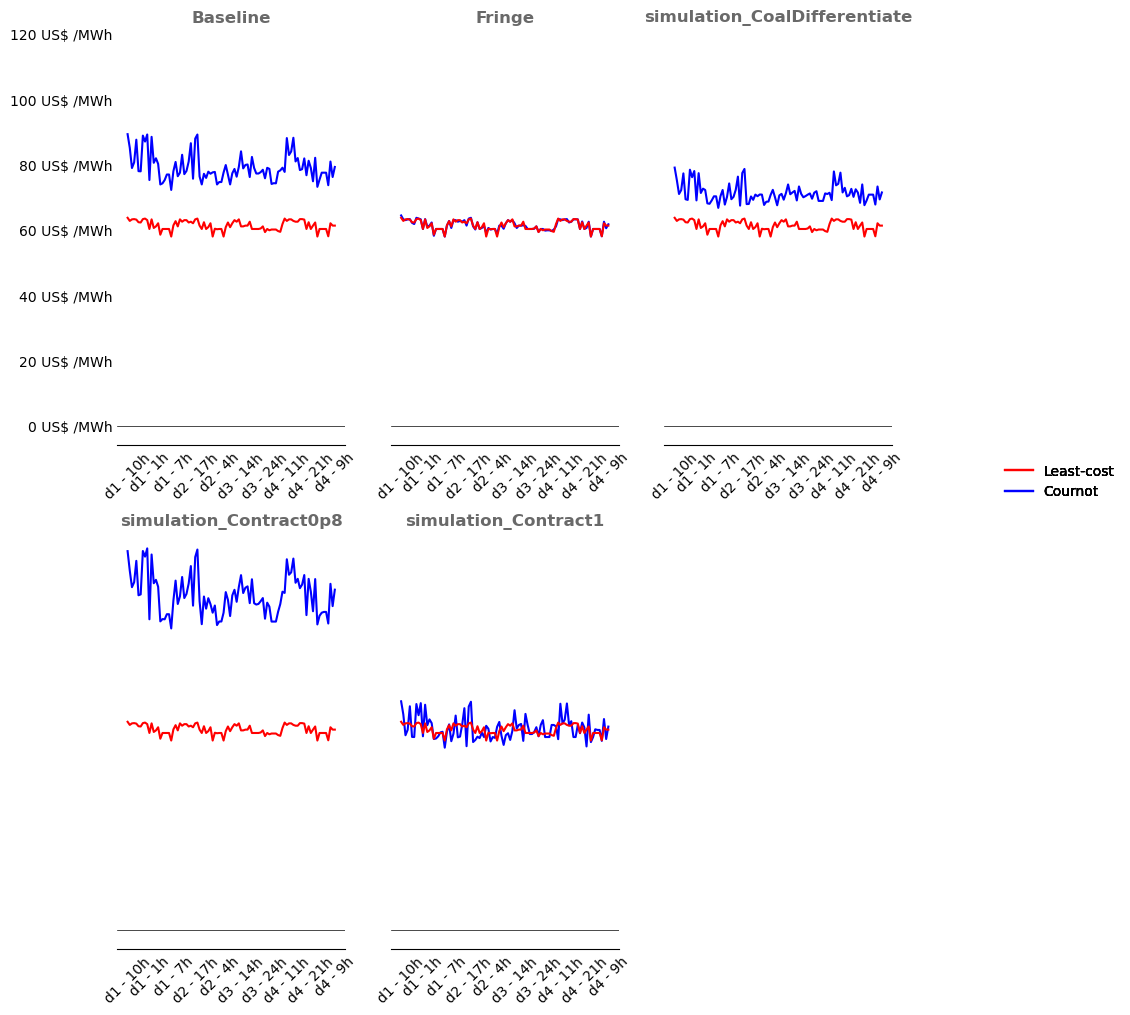

In [4]:
df = epm_results['pPrice'].copy()
df["hour"] = df["t"].str.extract(r"(\d+)").astype(int).astype(str) + "h"

df["day_hour"] = df["day"].astype(str) + " - " + df["hour"]
# df['value'] = df['value'] / 1e3
# df = df.loc[(df.season == 'Q1') & (df.day == 'd1')]
df = df.loc[(df.season == 'Q1')]

filename = None

make_multiple_lines_subplots(df, filename, dict_specs['colors'], column_subplots='scenario', column_xaxis='day_hour',
                          column_value='value', column_multiple_lines='competition',
                          format_y=lambda y, _: '{:.0f} US$ /MWh'.format(y), annotation_format="{:.0f}",
                             max_ticks=10, rotation=45)

## Generation

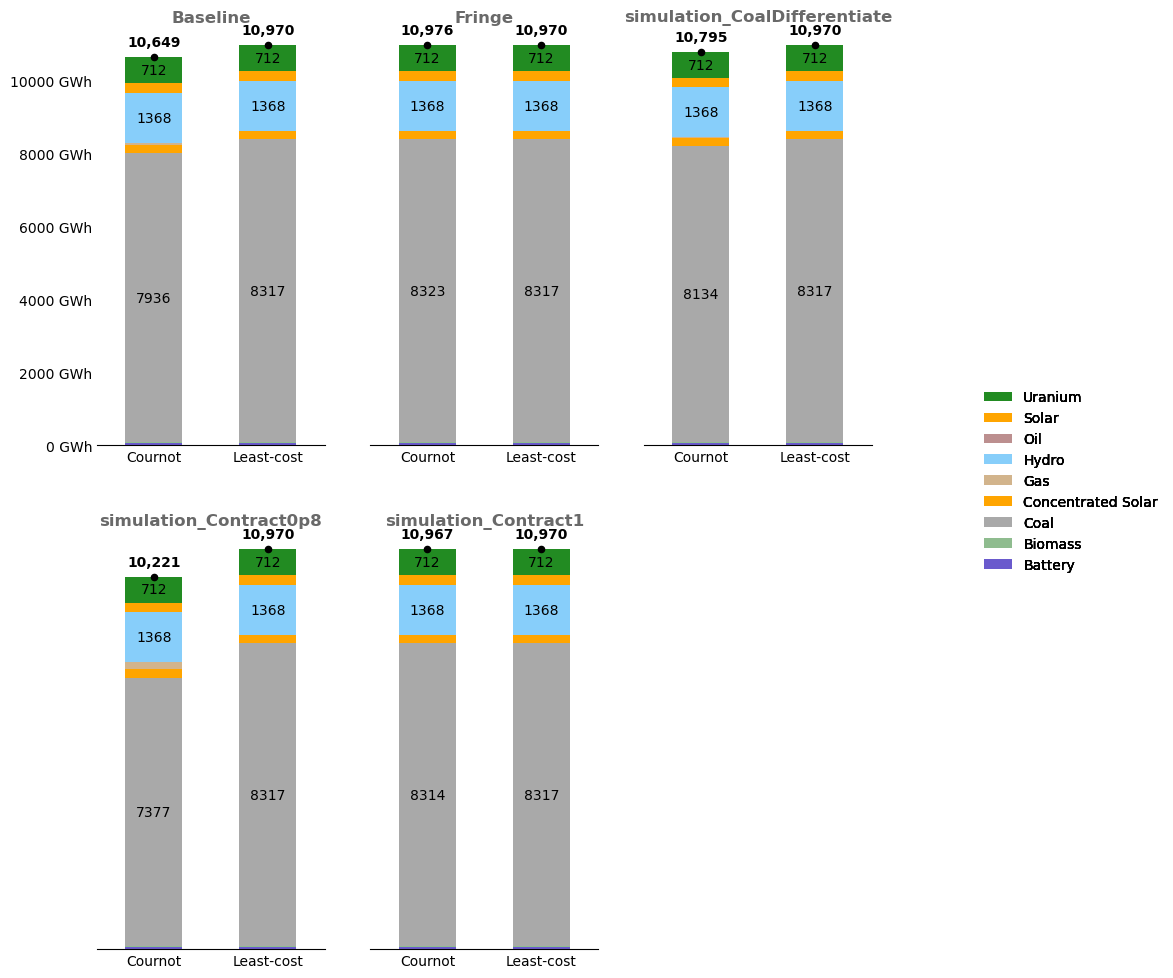

In [5]:
df = epm_results['pEnergyByFuel'].copy()
df['value'] = df['value'] / 1e3
filename = None
make_stacked_bar_subplots(df, filename, dict_specs['colors'], column_stacked='fuel', column_subplots='scenario',
                          column_value='value', column_multiple_bars='competition',
                          format_y=lambda y, _: '{:.0f} GWh'.format(y), annotation_format="{:.0f}", cap=500, show_total=True)

### Evolution by plant

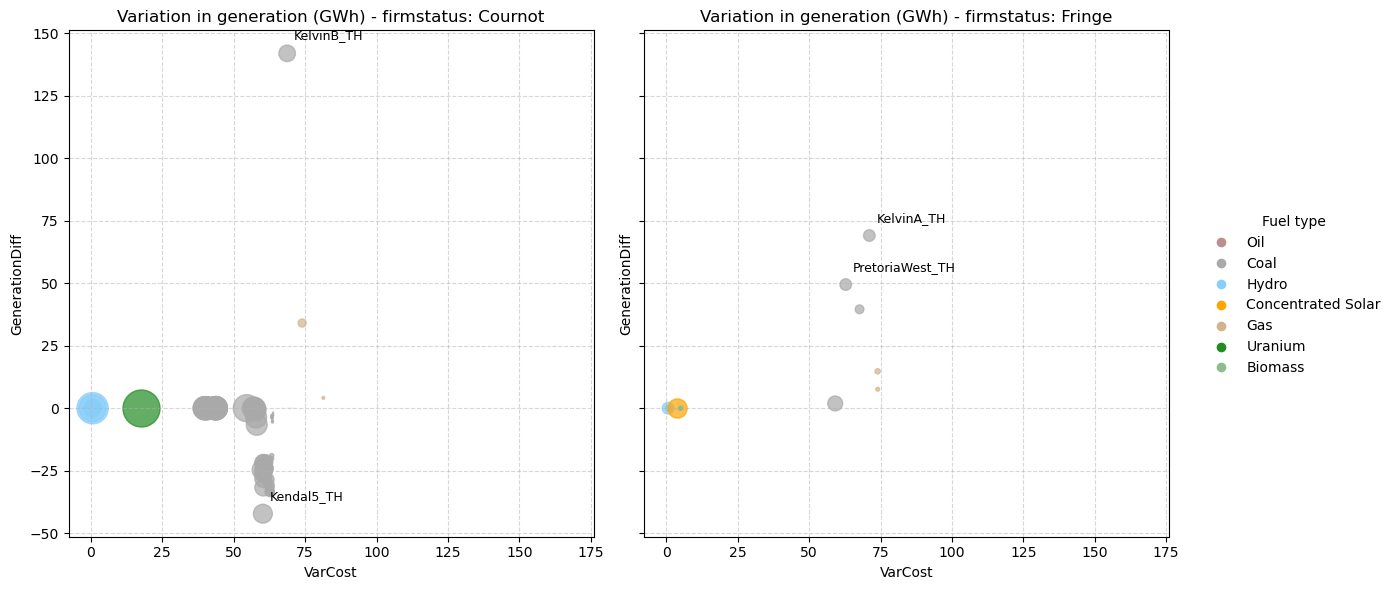

In [6]:
x_column = 'VarCost'
y_column = 'GenerationDiff'
color_col = 'fuel'
column_annotate = 'GenerationDiff'
column_scale = 'generation Cournot'
scenario = 'Baseline'

tmp = epm_results['pGenSupplyWithCost'].copy().set_index(['scenario', 'competition', 'generator', 'year', 'season', 'day', 't', 'VarCost', 'fuel', 'tech', 'firm', 'firmstatus']).unstack('competition')
tmp = tmp.reset_index()
tmp.columns = [' '.join(col).strip() for col in tmp.columns.values]
# sum over all year
tmp = tmp.loc[(tmp.scenario == scenario)].groupby(['scenario', 'generator', 'fuel', 'firmstatus', 'VarCost'], observed=False)[['generation Cournot', 'generation Least-cost']].sum().reset_index()

tmp.loc[:, 'GenerationDiff'] = (tmp.loc[:, 'generation Cournot'] - tmp.loc[:, 'generation Least-cost']) 
tmp = tmp.dropna()
tmp = tmp[tmp['GenerationDiff'] != 0]
tmp.loc[:, 'GenerationDiff'] = tmp.loc[:, 'GenerationDiff'] * 1e-3
# tmp = tmp.loc[(tmp.scenario == scenario) & (tmp.season == 'Q1') & (tmp.day == 'd1') & (tmp.t == 't15')]
tmp = tmp.loc[(tmp.scenario == scenario)]

filename = None # Only for display in the notebook
subplot_scatter(tmp, x_column, y_column, color_col, dict_specs['colors'],
                            ymax=None, title='Variation in generation (GWh)', legend='Fuel type',
                            filename=filename, xmax=None, size_scale=0.001, column_scale=column_scale, annotate_thresh=40, column_annotate=column_annotate,
                             subplot_column='firmstatus', figsize=(6,6)
                             )

## Dispatch

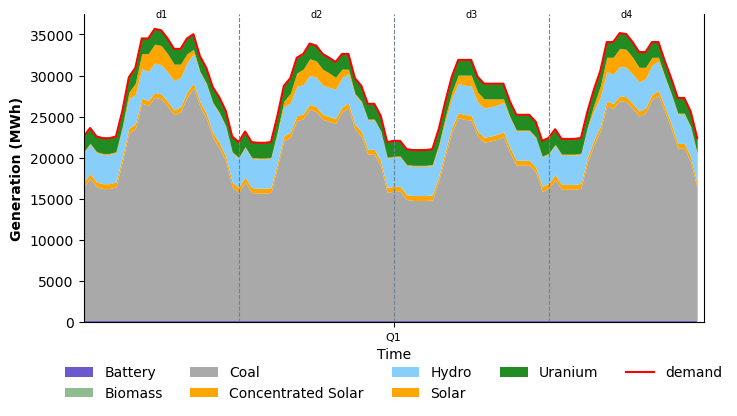

In [7]:
dfs_to_plot_area = {
    'pEnergyByFuelDispatch': epm_results['pEnergyByFuelDispatch'],
}

dfs_to_plot_line = {
    'pDemand': epm_results['pDemand']
}

selected_scenario = 'Fringe'
competition = 'Least-cost'

filename = None # Only for display in the notebook

select_time = {
    'season': ['Q1'],
    'day': ['d1', 'd2', 'd3', 'd4']
}

make_complete_fuel_dispatch_plot(dfs_to_plot_area, dfs_to_plot_line, dict_colors=dict_specs['colors'],
                                 year=2025, scenario=selected_scenario, competition=competition, zone=REGION_NAME,
                                 fuel_grouping=None, select_time=select_time, filename=filename,
                                 figsize=(8,4))   